In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

        Dataset  Accuracy  F1-score  Precision   Recall   AUC-ROC
0  Datos Reales   0.85179  0.850604   0.851302  0.85179  0.973984


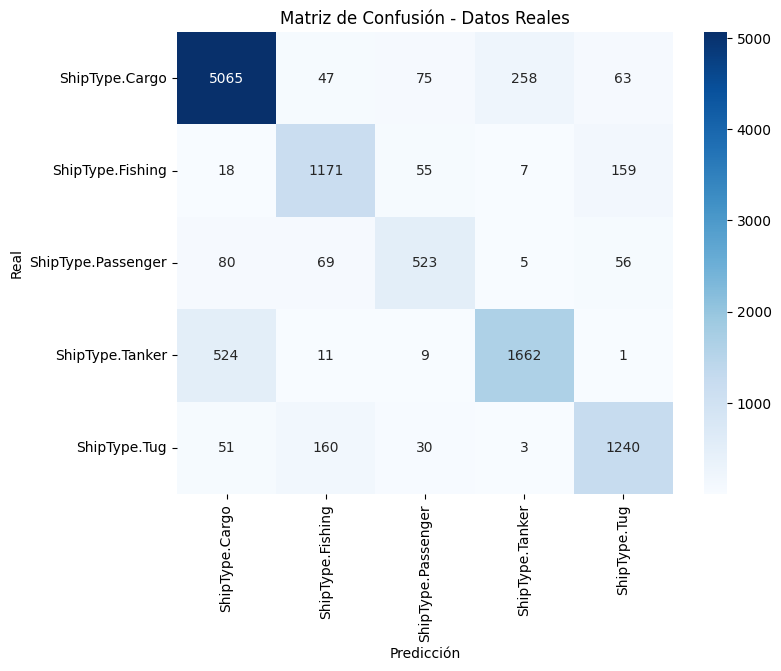

/tmp/ipykernel_260407/954959726.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Característica', y='Importancia', palette='viridis')


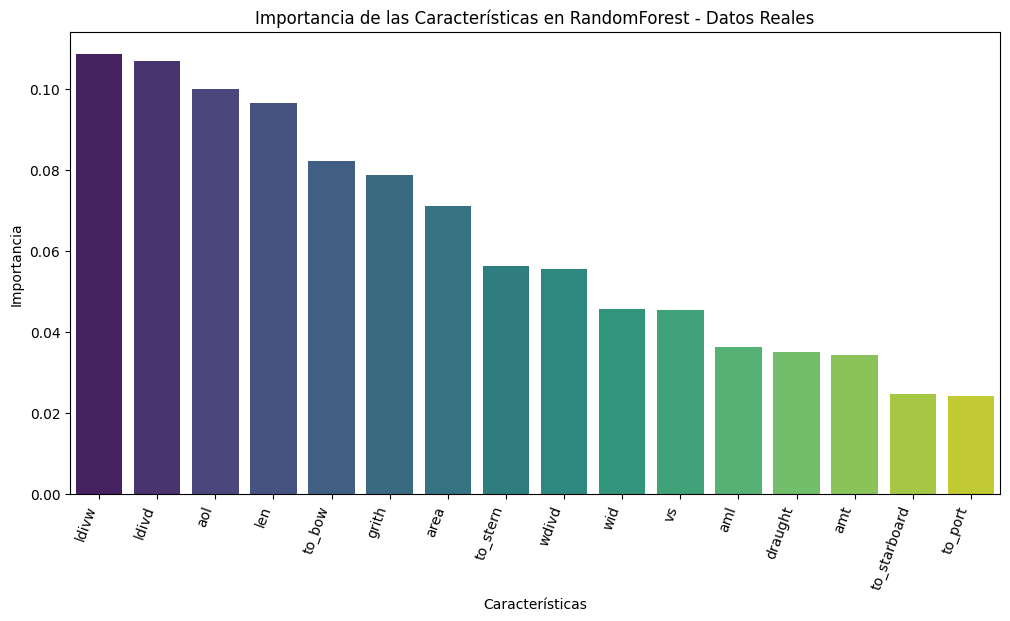

In [6]:
# Cargar los datos reales
real_data = pd.read_csv("final_static_data.csv").drop(columns=["Unnamed: 0","MMSI"], errors='ignore')

# Reemplazar valores infinitos por NaN y luego eliminarlos
real_data.replace([np.inf, -np.inf], np.nan, inplace=True)
real_data.dropna(inplace=True)

# Separar datos en train y test 
df_train, df_test = train_test_split(real_data, random_state=43)
x_train = df_train.drop(columns=['shiptype'])
y_train = df_train['shiptype']
x_test = df_test.drop(columns=['shiptype'])
y_test = df_test['shiptype']

# Binarizar etiquetas para calcular AUC-ROC
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)

# Crear modelo con pipeline
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenar el modelo con los datos reales
model = pipe.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Verificar si el clasificador soporta predict_proba
if hasattr(model.named_steps['classifier'], "predict_proba"):
    y_pred_proba = model.predict_proba(x_test)
    # Calcular AUC-ROC
    try:
        if len(classes) > 2:
            auc_roc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
        else:
            auc_roc = roc_auc_score(y_test_bin.ravel(), y_pred_proba[:, 1])
    except ValueError:
        print("No se pudo calcular AUC-ROC para los datos reales")
        auc_roc = np.nan
else:
    auc_roc = np.nan

# Obtener métricas
report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
accuracy = report['accuracy']
f1 = report['weighted avg']['f1-score']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']

# Mostrar resultados
results = pd.DataFrame({
    "Dataset": ["Datos Reales"],
    "Accuracy": [accuracy],
    "F1-score": [f1],
    "Precision": [precision],
    "Recall": [recall],
    "AUC-ROC": [auc_roc],
})
print(results)

# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Datos Reales")
plt.show()

# Obtener importancia de características
feature_importances = model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Característica': x_train.columns,
    'Importancia': feature_importances
}).sort_values(by='Importancia', ascending=False)

# Graficar importancia de características
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Característica', y='Importancia', palette='viridis')
plt.xticks(rotation=70, ha='right')
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de las Características en RandomForest - Datos Reales")
plt.show()
